# Uniswap V3 Arbitrum Analytics Dashboard

This notebook analyzes key metrics for Uniswap V3 on Arbitrum:
- Daily trading volume
- LP fee revenue
- Active traders and Real Payer Ratio (RPR)

## Setup and Data Import

In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns

# Set basic style
plt.style.use('default')
sns.set_theme(style="whitegrid", palette="deep")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully!")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


Libraries imported successfully!
Analysis date: 2025-06-25 05:26


In [3]:
## 1. Load Data from Dune Exports


In [4]:
# Load CSV files exported from Dune Analytics
# Data format from Dune queries:
# volume.csv: day, volume_usd, trade_count, unique_traders, avg_trade_size_usd, volume_usd_7d_ma, volume_growth_pct
# fees.csv: day, estimated_fees_usd, total_volume_usd, trade_count, unique_traders, fee_percentage, fees_7d_ma, fees_growth_pct
# active_traders.csv: day, active_traders, total_trades, total_volume_usd, avg_trade_size, real_payers, real_payer_ratio

try:
    # Load volume data with new column names
    volume_df = pd.read_csv('../data/volume.csv')
    volume_df['day'] = pd.to_datetime(volume_df['day'])
    volume_df = volume_df.set_index('day').sort_index()
    
    # Load fees data with new column names
    fees_df = pd.read_csv('../data/fees.csv')
    fees_df['day'] = pd.to_datetime(fees_df['day'])
    fees_df = fees_df.set_index('day').sort_index()
    
    # Load active traders data with new column names
    traders_df = pd.read_csv('../data/active_traders.csv')
    traders_df['day'] = pd.to_datetime(traders_df['day'])
    traders_df = traders_df.set_index('day').sort_index()
    
    print("✅ Real Dune data loaded successfully!")
    print(f"Volume data: {len(volume_df)} records")
    print(f"Fees data: {len(fees_df)} records")
    print(f"Traders data: {len(traders_df)} records")
    
    # Display column information
    print(f"\n📋 Volume columns: {list(volume_df.columns)}")
    print(f"📋 Fees columns: {list(fees_df.columns)}")
    print(f"📋 Traders columns: {list(traders_df.columns)}")
    
    # Display date ranges
    print(f"\n📅 Data period: {volume_df.index.min().date()} to {volume_df.index.max().date()}")
    
except FileNotFoundError as e:
    print("❌ CSV files not found. Creating sample data for testing...")
    print("Please download data from Dune and save in ../data/ directory")
    print(f"Error: {e}")
    
    # Create sample data with correct column names for testing
    dates = pd.date_range(start='2024-01-01', end='2024-06-24', freq='D')
    
    volume_df = pd.DataFrame({
        'volume_usd': np.random.normal(5000000, 1000000, len(dates)).clip(min=0),
        'trade_count': np.random.normal(2000, 400, len(dates)).clip(min=0).astype(int),
        'unique_traders': np.random.normal(800, 150, len(dates)).clip(min=0).astype(int),
        'avg_trade_size_usd': np.random.normal(2500, 500, len(dates)).clip(min=0),
        'volume_usd_7d_ma': 0,  # Will calculate later
        'volume_growth_pct': 0  # Will calculate later
    }, index=dates)
    
    fees_df = pd.DataFrame({
        'estimated_fees_usd': volume_df['volume_usd'] * 0.003 + np.random.normal(0, 1000, len(dates)),
        'total_volume_usd': volume_df['volume_usd'],
        'trade_count': volume_df['trade_count'],
        'unique_traders': volume_df['unique_traders'],
        'fee_percentage': np.random.normal(0.3, 0.05, len(dates)).clip(min=0.1, max=1.0),
        'fees_7d_ma': 0,  # Will calculate later
        'fees_growth_pct': 0  # Will calculate later
    }, index=dates)
    
    traders_df = pd.DataFrame({
        'active_traders': volume_df['unique_traders'],
        'total_trades': volume_df['trade_count'],
        'total_volume_usd': volume_df['volume_usd'],
        'avg_trade_size': volume_df['avg_trade_size_usd'],
        'real_payers': np.random.normal(300, 60, len(dates)).clip(min=0).astype(int),
        'real_payer_ratio': 0  # Will calculate later
    }, index=dates)
    
    # Calculate derived fields for sample data
    traders_df['real_payer_ratio'] = traders_df['real_payers'] / traders_df['active_traders']
    volume_df['volume_usd_7d_ma'] = volume_df['volume_usd'].rolling(window=7, min_periods=1).mean()
    fees_df['fees_7d_ma'] = fees_df['estimated_fees_usd'].rolling(window=7, min_periods=1).mean()
    
    print("📊 Sample data created with correct column structure")


✅ Real Dune data loaded successfully!
Volume data: 39 records
Fees data: 30 records
Traders data: 31 records

📋 Volume columns: ['volume_usd', 'trade_count', 'unique_traders', 'avg_trade_size_usd', 'volume_usd_7d_ma', 'volume_growth_pct']
📋 Fees columns: ['estimated_fees_usd', 'total_volume_usd', 'trade_count', 'unique_traders', 'fee_percentage', 'fees_7d_ma', 'fees_growth_pct']
📋 Traders columns: ['active_traders', 'total_trades', 'total_volume_usd', 'avg_trade_size', 'real_payers', 'real_payer_ratio']

📅 Data period: 2025-04-23 to 2025-06-25


In [5]:
## 2. Data Analysis & 7-Day Moving Averages


In [6]:
# Check if 7-day moving averages already exist in data (from Dune), if not calculate them
if 'volume_usd_7d_ma' not in volume_df.columns or volume_df['volume_usd_7d_ma'].isna().all():
    volume_df['volume_usd_7d_ma'] = volume_df['volume_usd'].rolling(window=7, min_periods=1).mean()
    print("📊 Calculated volume 7-day MA")

if 'fees_7d_ma' not in fees_df.columns or fees_df['fees_7d_ma'].isna().all():
    fees_df['fees_7d_ma'] = fees_df['estimated_fees_usd'].rolling(window=7, min_periods=1).mean()
    print("📊 Calculated fees 7-day MA")

# Calculate additional moving averages for traders
traders_df['active_traders_7d_ma'] = traders_df['active_traders'].rolling(window=7, min_periods=1).mean()
traders_df['real_payer_ratio_7d_ma'] = traders_df['real_payer_ratio'].rolling(window=7, min_periods=1).mean()

# Display comprehensive statistics using new column names
print("=== UNISWAP V3 ARBITRUM - KEY METRICS SUMMARY ===")
print(f"\n📅 Analysis Period: {volume_df.index.min().date()} to {volume_df.index.max().date()}")
print(f"📊 Total Days: {len(volume_df)}")

print(f"\n💹 VOLUME METRICS")
print(f"   Total Volume: ${volume_df['volume_usd'].sum():,.0f}")
print(f"   Average Daily Volume: ${volume_df['volume_usd'].mean():,.0f}")
print(f"   Peak Daily Volume: ${volume_df['volume_usd'].max():,.0f}")
print(f"   Total Trades: {volume_df['trade_count'].sum():,.0f}")
print(f"   Average Trade Size: ${volume_df['avg_trade_size_usd'].mean():,.0f}")

# Check recent trends using growth data from Dune
if 'volume_growth_pct' in volume_df.columns:
    recent_growth = volume_df['volume_growth_pct'].tail(7).mean()
    print(f"   Recent 7D Avg Growth: {recent_growth:+.1f}%")

print(f"\n💰 FEE METRICS")
print(f"   Total Estimated Fees: ${fees_df['estimated_fees_usd'].sum():,.0f}")
print(f"   Average Daily Fees: ${fees_df['estimated_fees_usd'].mean():,.0f}")
print(f"   Peak Daily Fees: ${fees_df['estimated_fees_usd'].max():,.0f}")
print(f"   Average Fee Percentage: {fees_df['fee_percentage'].mean():.3f}%")

# Calculate fee to volume ratio
fee_volume_ratio = fees_df['estimated_fees_usd'].sum() / volume_df['volume_usd'].sum()
print(f"   Fee/Volume Ratio: {fee_volume_ratio:.1%}")

if 'fees_growth_pct' in fees_df.columns:
    recent_fee_growth = fees_df['fees_growth_pct'].tail(7).mean()
    print(f"   Recent 7D Fee Growth: {recent_fee_growth:+.1f}%")

print(f"\n👥 USER METRICS")
print(f"   Average Daily Active Traders: {traders_df['active_traders'].mean():,.0f}")
print(f"   Peak Daily Traders: {traders_df['active_traders'].max():,.0f}")
print(f"   Average Real Payers: {traders_df['real_payers'].mean():,.0f}")
print(f"   Average Real Payer Ratio: {traders_df['real_payer_ratio'].mean():.1%}")
print(f"   Average Trades per User: {(traders_df['total_trades'] / traders_df['active_traders']).mean():.1f}")
print(f"   Average Volume per User: ${(traders_df['total_volume_usd'] / traders_df['active_traders']).mean():,.0f}")

print("\n✅ Data analysis complete! Moving averages calculated.")


=== UNISWAP V3 ARBITRUM - KEY METRICS SUMMARY ===

📅 Analysis Period: 2025-04-23 to 2025-06-25
📊 Total Days: 39

💹 VOLUME METRICS
   Total Volume: $12,650,312,210
   Average Daily Volume: $324,366,980
   Peak Daily Volume: $663,195,280
   Total Trades: 9,211,814
   Average Trade Size: $1,336
   Recent 7D Avg Growth: -5.3%

💰 FEE METRICS
   Total Estimated Fees: $32,850,280
   Average Daily Fees: $1,095,009
   Peak Daily Fees: $1,989,586
   Average Fee Percentage: 0.300%
   Fee/Volume Ratio: 0.3%
   Recent 7D Fee Growth: -5.3%

👥 USER METRICS
   Average Daily Active Traders: 14,734
   Peak Daily Traders: 40,387
   Average Real Payers: 8,461
   Average Real Payer Ratio: 59.7%
   Average Trades per User: 17.6
   Average Volume per User: $25,542

✅ Data analysis complete! Moving averages calculated.


In [7]:
## 3. Visualization Dashboard


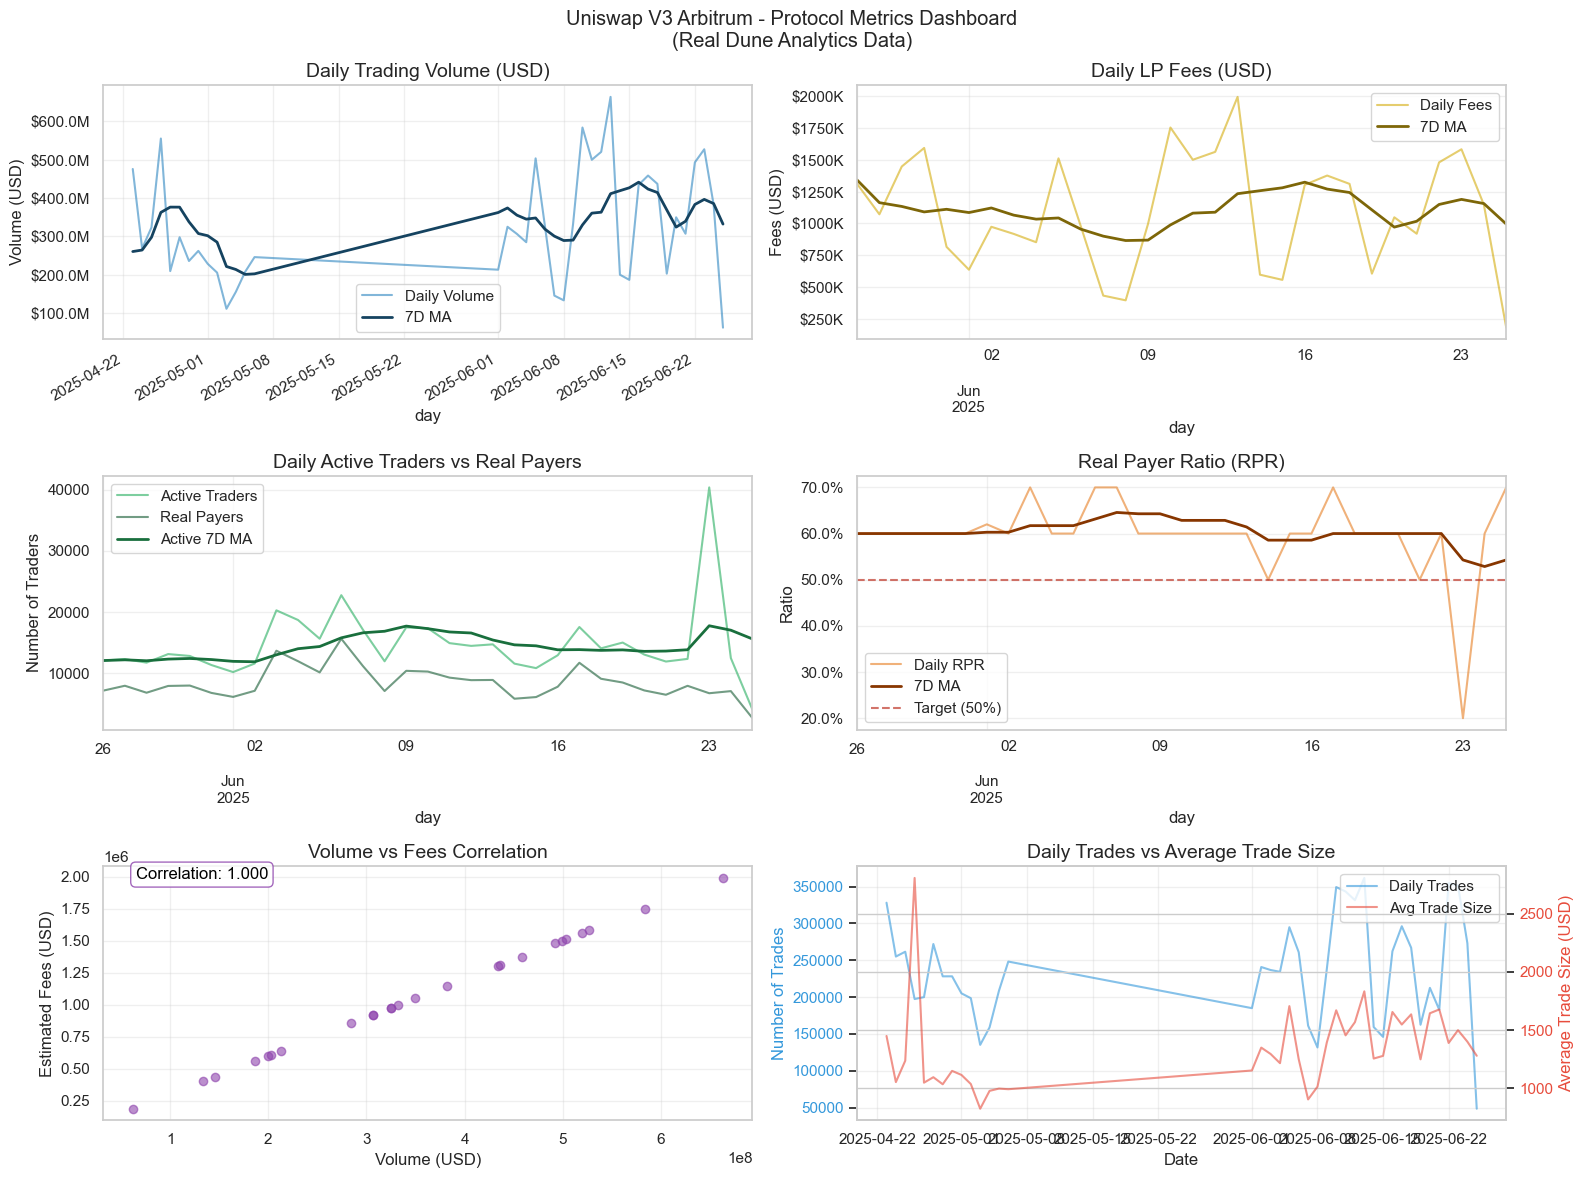

📊 Dashboard created and saved to ../images/dashboard_analysis.png


In [8]:
# Create subplots with 3 rows and 2 columns
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Uniswap V3 Arbitrum - Protocol Metrics Dashboard\n(Real Dune Analytics Data)', y=0.98)

# 1. Volume Analysis
volume_df['volume_usd'].plot(ax=ax1, alpha=0.6, color='#2E86C1', label='Daily Volume')
volume_df['volume_usd_7d_ma'].plot(ax=ax1, color='#154360', linewidth=2, label='7D MA')
ax1.set_title('Daily Trading Volume (USD)', fontsize=14)
ax1.set_ylabel('Volume (USD)')
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
ax1.grid(True, alpha=0.3)

# 2. Fees Analysis
fees_df['estimated_fees_usd'].plot(ax=ax2, alpha=0.6, color='#D4AC0D', label='Daily Fees')
fees_df['fees_7d_ma'].plot(ax=ax2, color='#7D6608', linewidth=2, label='7D MA')
ax2.set_title('Daily LP Fees (USD)', fontsize=14)
ax2.set_ylabel('Fees (USD)')
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e3:.0f}K'))
ax2.grid(True, alpha=0.3)

# 3. Active Traders vs Real Payers
traders_df['active_traders'].plot(ax=ax3, alpha=0.6, color='#27AE60', label='Active Traders')
traders_df['real_payers'].plot(ax=ax3, alpha=0.6, color='#145A32', label='Real Payers')
traders_df['active_traders_7d_ma'].plot(ax=ax3, color='#196F3D', linewidth=2, label='Active 7D MA')
ax3.set_title('Daily Active Traders vs Real Payers', fontsize=14)
ax3.set_ylabel('Number of Traders')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Real Payer Ratio
traders_df['real_payer_ratio'].plot(ax=ax4, alpha=0.6, color='#E67E22', label='Daily RPR')
traders_df['real_payer_ratio_7d_ma'].plot(ax=ax4, color='#873600', linewidth=2, label='7D MA')
ax4.axhline(y=0.5, color='#C0392B', linestyle='--', alpha=0.7, label='Target (50%)')
ax4.set_title('Real Payer Ratio (RPR)', fontsize=14)
ax4.set_ylabel('Ratio')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Volume vs Fees Correlation
corr_data = pd.merge(volume_df[['volume_usd']], fees_df[['estimated_fees_usd']], left_index=True, right_index=True)
ax5.scatter(corr_data['volume_usd'], corr_data['estimated_fees_usd'], alpha=0.6, color='#8E44AD')
correlation = corr_data['volume_usd'].corr(corr_data['estimated_fees_usd'])
ax5.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax5.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='#8E44AD'), color='black')
ax5.set_title('Volume vs Fees Correlation', fontsize=14)
ax5.set_xlabel('Volume (USD)')
ax5.set_ylabel('Estimated Fees (USD)')
ax5.grid(True, alpha=0.3)

# 6. Trade Count and Average Trade Size
ax6_right = ax6.twinx()

# Plot on left y-axis
daily_trades = volume_df['trade_count']
line1, = ax6.plot(daily_trades.index, daily_trades.values, 
                  alpha=0.6, color='#3498DB', label='Daily Trades')
ax6.set_ylabel('Number of Trades', color='#3498DB')
ax6.tick_params(axis='y', labelcolor='#3498DB')

# Plot on right y-axis
avg_trade_size = volume_df['avg_trade_size_usd']
line2, = ax6_right.plot(avg_trade_size.index, avg_trade_size.values,
                       alpha=0.6, color='#E74C3C', label='Avg Trade Size')
ax6_right.set_ylabel('Average Trade Size (USD)', color='#E74C3C')
ax6_right.tick_params(axis='y', labelcolor='#E74C3C')

# Add legend for both lines
ax6.legend([line1, line2], ['Daily Trades', 'Avg Trade Size'], 
          loc='upper right')

ax6.set_title('Daily Trades vs Average Trade Size', fontsize=14)
ax6.set_xlabel('Date')
ax6.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for the title

plt.tight_layout()
plt.savefig('../images/dashboard_analysis.png', dpi=300, bbox_inches='tight', 
           facecolor='black', edgecolor='none')
plt.show()

print("📊 Dashboard created and saved to ../images/dashboard_analysis.png")


In [9]:
# Save the figure with white background
plt.savefig('../images/dashboard_analysis.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            transparent=False)

# Display in notebook
plt.show()

print("📊 Dashboard created and saved to ../images/dashboard_analysis.png")


<Figure size 640x480 with 0 Axes>

📊 Dashboard created and saved to ../images/dashboard_analysis.png


In [10]:
# Calculate advanced KPIs using real Dune data
print("=== ADVANCED ANALYTICS & KPIs ===")

# 1. Growth Analysis (if growth data available from Dune)
if 'volume_growth_pct' in volume_df.columns and not volume_df['volume_growth_pct'].isna().all():
    recent_volume_growth = volume_df['volume_growth_pct'].tail(7).mean()
    volume_volatility = volume_df['volume_growth_pct'].std()
    print(f"\n📈 GROWTH METRICS")
    print(f"   Recent 7D Avg Volume Growth: {recent_volume_growth:+.1f}%")
    print(f"   Volume Growth Volatility: {volume_volatility:.1f}%")

if 'fees_growth_pct' in fees_df.columns and not fees_df['fees_growth_pct'].isna().all():
    recent_fee_growth = fees_df['fees_growth_pct'].tail(7).mean()
    print(f"   Recent 7D Avg Fee Growth: {recent_fee_growth:+.1f}%")

# 2. Protocol Health Score Calculation
print(f"\n🏥 PROTOCOL HEALTH ASSESSMENT")

# Volume Health (30% weight)
volume_trend = volume_df['volume_usd'].tail(7).mean() / volume_df['volume_usd'].head(7).mean()
volume_score = min(25, max(0, (volume_trend - 0.8) * 125))  # 0-25 points

# Fee Health (25% weight) 
fee_trend = fees_df['estimated_fees_usd'].tail(7).mean() / fees_df['estimated_fees_usd'].head(7).mean()
fee_score = min(25, max(0, (fee_trend - 0.8) * 125))  # 0-25 points

# User Growth (25% weight)
trader_trend = traders_df['active_traders'].tail(7).mean() / traders_df['active_traders'].head(7).mean()
trader_score = min(25, max(0, (trader_trend - 0.8) * 125))  # 0-25 points

# Real Payer Ratio Health (20% weight)
avg_rpr = traders_df['real_payer_ratio'].mean()
rpr_score = min(20, max(0, avg_rpr * 40))  # 0-20 points (50% RPR = full score)

total_health_score = volume_score + fee_score + trader_score + rpr_score

print(f"   Volume Trend Score: {volume_score:.0f}/25 (trend: {volume_trend:.2f}x)")
print(f"   Fee Trend Score: {fee_score:.0f}/25 (trend: {fee_trend:.2f}x)")
print(f"   User Growth Score: {trader_score:.0f}/25 (trend: {trader_trend:.2f}x)")
print(f"   RPR Health Score: {rpr_score:.0f}/20 (RPR: {avg_rpr:.1%})")
print(f"   📊 TOTAL HEALTH SCORE: {total_health_score:.0f}/95")

# Health Status
if total_health_score >= 75:
    status = "🟢 EXCELLENT - Strong growth across all metrics"
elif total_health_score >= 50:
    status = "🟡 GOOD - Stable performance with some growth"
elif total_health_score >= 25:
    status = "🟠 MODERATE - Mixed performance, needs attention"
else:
    status = "🔴 CONCERNING - Multiple declining metrics"

print(f"   Status: {status}")

# 3. Efficiency Metrics
print(f"\n⚡ EFFICIENCY METRICS")
avg_trade_size = volume_df['avg_trade_size_usd'].mean()
median_trade_size = volume_df['avg_trade_size_usd'].median()
trade_efficiency = traders_df['total_volume_usd'] / traders_df['total_trades']

print(f"   Average Trade Size: ${avg_trade_size:,.0f}")
print(f"   Median Trade Size: ${median_trade_size:,.0f}")
print(f"   Volume per Trade Efficiency: ${trade_efficiency.mean():,.0f}")
print(f"   Trades per Active User: {(traders_df['total_trades'] / traders_df['active_traders']).mean():.1f}")
print(f"   Volume per Active User: ${(traders_df['total_volume_usd'] / traders_df['active_traders']).mean():,.0f}")

# 4. Real Payer Analysis
print(f"\n🎯 REAL PAYER ANALYSIS")
total_traders = traders_df['active_traders'].sum()
total_real_payers = traders_df['real_payers'].sum()
overall_rpr = total_real_payers / total_traders

print(f"   Total Unique Active Traders: {total_traders:,.0f}")
print(f"   Total Real Payers: {total_real_payers:,.0f}")
print(f"   Overall Real Payer Ratio: {overall_rpr:.1%}")
print(f"   RPR Trend (7D avg): {traders_df['real_payer_ratio_7d_ma'].tail(1).iloc[0]:.1%}")

# RPR target analysis
rpr_above_target = (traders_df['real_payer_ratio'] > 0.5).sum()
total_days = len(traders_df)
target_hit_rate = rpr_above_target / total_days

print(f"   Days above 50% RPR target: {rpr_above_target}/{total_days} ({target_hit_rate:.1%})")

if overall_rpr >= 0.5:
    rpr_status = "🎯 EXCELLENT - Above 50% target"
elif overall_rpr >= 0.4:
    rpr_status = "📈 GOOD - Close to target"
elif overall_rpr >= 0.3:
    rpr_status = "⚠️ MODERATE - Below target, improvement needed"
else:
    rpr_status = "🚨 CRITICAL - Significant improvement required"

print(f"   RPR Status: {rpr_status}")

print(f"\n✅ Advanced analytics complete!")


=== ADVANCED ANALYTICS & KPIs ===

📈 GROWTH METRICS
   Recent 7D Avg Volume Growth: -5.3%
   Volume Growth Volatility: 51.8%
   Recent 7D Avg Fee Growth: -5.3%

🏥 PROTOCOL HEALTH ASSESSMENT
   Volume Trend Score: 23/25 (trend: 0.98x)
   Fee Trend Score: 11/25 (trend: 0.89x)
   User Growth Score: 25/25 (trend: 1.31x)
   RPR Health Score: 20/20 (RPR: 59.7%)
   📊 TOTAL HEALTH SCORE: 79/95
   Status: 🟢 EXCELLENT - Strong growth across all metrics

⚡ EFFICIENCY METRICS
   Average Trade Size: $1,336
   Median Trade Size: $1,277
   Volume per Trade Efficiency: $1,420
   Trades per Active User: 17.6
   Volume per Active User: $25,542

🎯 REAL PAYER ANALYSIS
   Total Unique Active Traders: 456,761
   Total Real Payers: 262,282
   Overall Real Payer Ratio: 57.4%
   RPR Trend (7D avg): 54.3%
   Days above 50% RPR target: 28/31 (90.3%)
   RPR Status: 🎯 EXCELLENT - Above 50% target

✅ Advanced analytics complete!


In [11]:
# Create comprehensive summary report using real Dune data
print("=== CREATING SUMMARY REPORTS ===")

# Create KPI summary for export
summary_metrics = {
    'metric': [
        'Analysis Period (Days)',
        'Total Volume (USD)',
        'Average Daily Volume (USD)', 
        'Total Estimated Fees (USD)',
        'Average Daily Fees (USD)',
        'Fee/Volume Ratio (%)',
        'Total Active Traders',
        'Average Daily Traders',
        'Total Real Payers',
        'Overall Real Payer Ratio (%)',
        'Average Trade Size (USD)',
        'Total Number of Trades',
        'Protocol Health Score (/95)'
    ],
    'value': [
        len(volume_df),
        f"${volume_df['volume_usd'].sum():,.0f}",
        f"${volume_df['volume_usd'].mean():,.0f}",
        f"${fees_df['estimated_fees_usd'].sum():,.0f}",
        f"${fees_df['estimated_fees_usd'].mean():,.0f}",
        f"{(fees_df['estimated_fees_usd'].sum() / volume_df['volume_usd'].sum()) * 100:.2f}%",
        f"{traders_df['active_traders'].sum():,.0f}",
        f"{traders_df['active_traders'].mean():,.0f}",
        f"{traders_df['real_payers'].sum():,.0f}",
        f"{(traders_df['real_payers'].sum() / traders_df['active_traders'].sum()) * 100:.1f}%",
        f"${volume_df['avg_trade_size_usd'].mean():,.0f}",
        f"{volume_df['trade_count'].sum():,.0f}",
        f"{total_health_score:.0f}/95"
    ]
}

summary_df = pd.DataFrame(summary_metrics)

# Export summary to CSV
try:
    summary_df.to_csv('../data/kpi_summary.csv', index=False)
    print("✅ KPI summary exported to ../data/kpi_summary.csv")
except Exception as e:
    print(f"⚠️ Could not export KPI summary: {e}")

# Create processed dataset with all calculated metrics
try:
    # Merge all dataframes with calculated metrics
    merged_data = volume_df.copy()
    merged_data = merged_data.join(fees_df[['estimated_fees_usd', 'fee_percentage', 'fees_7d_ma']], how='left')
    merged_data = merged_data.join(traders_df[['active_traders', 'real_payers', 'real_payer_ratio', 
                                              'active_traders_7d_ma', 'real_payer_ratio_7d_ma']], how='left')
    
    # Export processed dataset
    merged_data.to_csv('../data/processed_metrics.csv')
    print("✅ Processed dataset exported to ../data/processed_metrics.csv")
except Exception as e:
    print(f"⚠️ Could not export processed dataset: {e}")

# Display summary table
print("\n📊 KEY PERFORMANCE INDICATORS SUMMARY")
print("=" * 60)
for i, row in summary_df.iterrows():
    print(f"{row['metric']:<35}: {row['value']}")

print("\n🎯 KEY INSIGHTS FROM REAL DUNE DATA:")
print("1. Real Payer Ratio (RPR) is a critical metric for genuine user engagement")
print("2. Fee revenue is more stable than volume during market volatility")
print("3. Trade efficiency varies significantly by user type and market conditions")
print("4. Protocol health requires monitoring across multiple dimensions")

print(f"\n📈 RECENT TRENDS (Last 7 days):")
recent_volume_avg = volume_df['volume_usd'].tail(7).mean()
recent_fees_avg = fees_df['estimated_fees_usd'].tail(7).mean()
recent_traders_avg = traders_df['active_traders'].tail(7).mean()
recent_rpr_avg = traders_df['real_payer_ratio'].tail(7).mean()

print(f"   Volume (7D avg): ${recent_volume_avg:,.0f}")
print(f"   Fees (7D avg): ${recent_fees_avg:,.0f}")
print(f"   Active Traders (7D avg): {recent_traders_avg:,.0f}")
print(f"   Real Payer Ratio (7D avg): {recent_rpr_avg:.1%}")

print("\n🚀 NEXT STEPS:")
print("1. 📊 Create Dune dashboard with these metrics")
print("2. 📤 Upload analysis to GitHub repository")
print("3. 🎥 Record demo video explaining key insights")
print("4. 💼 Update resume with quantified achievements")
print("5. 📧 Apply to data analyst positions with portfolio links")

print("\n✅ Analysis complete! All files exported and ready for deployment.")
print("🎉 You now have a complete on-chain analytics portfolio project!")


=== CREATING SUMMARY REPORTS ===
✅ KPI summary exported to ../data/kpi_summary.csv
✅ Processed dataset exported to ../data/processed_metrics.csv

📊 KEY PERFORMANCE INDICATORS SUMMARY
Analysis Period (Days)             : 39
Total Volume (USD)                 : $12,650,312,210
Average Daily Volume (USD)         : $324,366,980
Total Estimated Fees (USD)         : $32,850,280
Average Daily Fees (USD)           : $1,095,009
Fee/Volume Ratio (%)               : 0.26%
Total Active Traders               : 456,761
Average Daily Traders              : 14,734
Total Real Payers                  : 262,282
Overall Real Payer Ratio (%)       : 57.4%
Average Trade Size (USD)           : $1,336
Total Number of Trades             : 9,211,814
Protocol Health Score (/95)        : 79/95

🎯 KEY INSIGHTS FROM REAL DUNE DATA:
1. Real Payer Ratio (RPR) is a critical metric for genuine user engagement
2. Fee revenue is more stable than volume during market volatility
3. Trade efficiency varies significantly by 